In [92]:
import numpy as np
import torch
import math
from random import randint, choice
import matplotlib.pyplot as plt
from util import *
from IPython.display import clear_output

In [115]:
class UAVEnvironment:
    """
    Game environment for UAV test
    
    ---Map---
    
    y-axis(length)
    |
    |
    |
    |
    |
    |
     _______________________ x-axis(width)
     
    Hight is a fixed value
    
    """
    def __init__(self, config):
        # Game config
        self.action_space = (1, 2, 3, 4) # up, right, down, left, total 4 actions
        self.total_steps = config["total_steps"] # when the game end
        self.current_step = 0
        
        # Map config
        self.map = dict(width=config["map"]["width"], length=config["map"]["length"], height=config["map"]["height"])
        self.UAV_speed = config["UAV_speed"]
        self.UAV_initial_pos = config["UAV_initial_pos"] # a tuple
        self.UAV_current_pos = self.UAV_initial_pos
        self.number_of_user = config["number_of_user"]
        self.users_pos = list()
        for i in range(0, self.number_of_user):
            self.users_pos.append((randint(0, self.map["width"]), randint(0, self.map["length"])))
        
        # Wireless config
        self.g0 = config["wireless_parameter"]["g0"]
        self.B = config["wireless_parameter"]["B"]
        self.Pk = config["wireless_parameter"]["Pk"]
        self.noise = config["wireless_parameter"]["noise"]
        
    def get_reward(self, UAV_pos):
        # One step Reward is define as the summation of all user's utility
        reward = 0
        for user_index in range(0, self.number_of_user):
            gkm = self.g0 / (self.map["height"] ** 2 + (UAV_pos[0] - self.users_pos[user_index][0]) ** 2 + (UAV_pos[1] - self.users_pos[user_index][1]) ** 2)
            user_utility = self.B * math.log(1 + self.Pk * gkm / self.noise, 2)
            reward = reward + user_utility
        return reward
    
    def transition_dynamics(self, action, speed, state):
        # given the action (direction), calculate the next state (UAV current position)
        assert action in self.action_space
        next_UAV_pos = list(state)
        if action == 1:
            # move up
            next_UAV_pos[1] = min(next_UAV_pos[1] + speed, self.map["length"])
        if action == 2:
            # move right
            next_UAV_pos[0] = min(next_UAV_pos[0] + speed, self.map["width"])
        if action == 3:
            # move down
            next_UAV_pos[1] = max(next_UAV_pos[1] - speed, 0)
        if action == 4:
            # move left
            next_UAV_pos[0] = max(next_UAV_pos[0] - speed, 0)
        return tuple(next_UAV_pos)
    
    def get_transition(self):
        # This function only works for model based, we are trying to disable this function to try more algorithm
        # Return a table of transition, we assume UAV use fixed flying speed
        """
        Structure:
        transition[
            x_0[
                y_0[
                    {next_state, reward}, # for action 1
                    {next_state, reward}, # for action 2
                    ...
                    {next_state, reward}, # for action 20
                ],
                y_1*v[],
                ...
                y_h-1*v[]
            ],
            x_1*v[],
            x_2*v[],
            ...
            x_w-1*v[]
        ]
        
        """
        transition = list()
        for state_x in range(0, int(self.map["width"] / self.UAV_speed)):
            transition.append(list())
            for state_y in range(0, int(self.map["height"] / self.UAV_speed)):
                transition[state_x].append(list())
                for action in self.action_space:
                    next_state = self.transition_dynamics(action, self.UAV_speed, (state_x * self.UAV_speed, state_y * self.UAV_speed))
                    reward = self.get_reward(next_state)
                    transition[state_x][state_y].append(dict(next_state=next_state, reward=reward))
        return transition
                    
    def step(self, action, speed=-1):
        # assume we use the max speed as the default speed, when come near to the opt-position, we can slow down the speed
        if speed < 0 or speed >= self.UAV_speed:
            speed = self.UAV_speed
            
        self.UAV_current_pos = self.transition_dynamics(action, speed, self.UAV_current_pos)
        self.current_step = self.current_step + 1
        done = False
        if self.current_step == self.total_steps:
            done =  True
        return self.UAV_current_pos, self.get_reward(self.UAV_current_pos), done
    
    def action_sample(self):
        return choice(self.action_space)
    
    def reset(self):
        self.current_step = 0
        self.UAV_current_pos = self.UAV_initial_pos
        self.users_pos = list()
        for i in range(0, self.number_of_user):
            self.users_pos.append((randint(0, self.map["width"]), randint(0, self.map["length"])))
        
    def print_attribute(self):
        attrs = vars(self)
        print(', '.join("%s: %s" % item for item in attrs.items()))
        
    def print_map(self):
        x_list = [pos[0] for pos in self.users_pos]
        y_list = [pos[1] for pos in self.users_pos]
        x_list.append(self.UAV_current_pos[0])
        y_list.append(self.UAV_current_pos[1])
        
        colors = np.array(["red", "green"])
        sizes = []
        colors_map = []
        for i in range(0, self.number_of_user):
            sizes.append(25)
            colors_map.append(1)
        sizes.append(50)
        colors_map.append(0)
        plt.scatter(x_list, y_list, c=colors[colors_map], s=sizes) 
        plt.axis([0, self.map["width"], 0, self.map["length"]])
        plt.show()
        

In [116]:
environment_config = dict(
    total_steps = 50,
    map=dict(
        width=1000,
        length=1000,
        height=100
    ),
    number_of_user = 10,
    UAV_speed = 20,
    UAV_initial_pos = (500, 500),
    wireless_parameter = dict(
        g0 = 10 ** (-5),
        B = 10 ** (6),
        Pk = 0.1,
        noise = 10 ** (-9)
    )
)

action_space: (1, 2, 3, 4), total_steps: 50, current_step: 0, map: {'width': 1000, 'length': 1000, 'height': 100}, UAV_speed: 20, UAV_initial_pos: (500, 500), UAV_current_pos: (500, 500), number_of_user: 10, users_pos: [(497, 100), (179, 684), (692, 64), (324, 116), (260, 392), (796, 458), (413, 218), (471, 953), (936, 82), (496, 538)], g0: 1e-05, B: 1000000, Pk: 0.1, noise: 1e-09


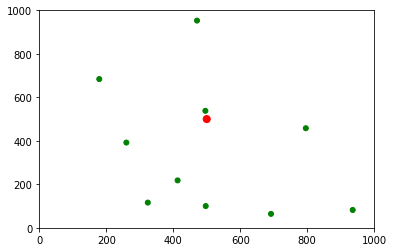

In [117]:
myGame = UAVEnvironment(environment_config)
myGame.print_attribute()
myGame.print_map()

In [118]:
def evaluate(policy, num_episodes=1, render=False):
    env = UAVEnvironment(environment_config)
    rewards = []
    for i in range(num_episodes):
        obs = env.reset()
        # all policy will return a direction and a speed
        act_direction, act_speed = policy(obs)
        ep_reward = 0
        while True:
            obs, reward, done = env.step(act_direction, act_speed)
            act_direction, act_speed = policy(obs)
            ep_reward += reward
            if done:
                break
            if render:
                clear_output(wait=True)
                print("Current Step: {}".format(env.current_step))
                print("Policy choice direction: {}, speed: {}".format(act_direction, act_speed))
                print("UAV current position x: {}, y: {}".format(env.UAV_current_pos[0], env.UAV_current_pos[1]))
                print("Current step reward: {}, episodes rewards: {}".format(reward, ep_reward))
                env.print_map()
                wait(sleep=0.2)
        rewards.append(ep_reward)
    return np.mean(rewards)


def run(trainer_cls, config=None, reward_threshold=None):
    pass


In [119]:
# Basic Class for all RL algorithm
class UAVTrainer: 
    def __init__(self, config):
        self.config = config
        self.env = UAVEnvironment(self.config)
                
    def compute_values(self, processed_state):
        pass
    
    def compute_action(self, processed_state):
        pass
    
    def train(self):
        pass

In [120]:
# Start from random policy
class UAVTrainerRandomPolicy(UAVTrainer):
    def __init__(self, config):
        super().__init__(config)
        
    def policy(self, obs):
        max_speed = self.env.UAV_speed
        return self.env.action_sample(), max_speed

random_policy_config = environment_config
trainer = UAVTrainerRandomPolicy(random_policy_config)
print("Mean Reward is: {}".format(evaluate(trainer.policy, num_episodes=1, render=False))) # Enable render=True can see the agent behavior

Mean Reward is: 3817017.032628813


In [121]:
# Value Iteration, Tabular, transition dynamic is known, assume only use fixed speed to reduce action space
class UAVTrainerValueIteration(UAVTrainer):
    def __init__(self, config):
        super().__init__(config)
        self.transitions = self.env.get_transition()

    def get_transition(self, state, act):
        transition = self.transitions[state[0]][state[1]][act]
        return transition["next_state"], transition["reward"]
    
    def print_transition(self):
        print(self.transitions)
        
    def policy(self, obs):
        max_speed = self.env.UAV_speed
        return self.env.action_sample(), max_speed

value_iteration_config = environment_config
trainer = UAVTrainerValueIteration(random_policy_config)
#trainer.print_transition()
#print("Mean Reward is: {}".format(evaluate(trainer.policy, num_episodes=1, render=False))) # Enable render=True can see the agent behavior

[[[{'next_state': (0, 20), 'reward': 39393.05428234502}, {'next_state': (20, 0), 'reward': 40879.67966160981}, {'next_state': (0, 0), 'reward': 38025.99477021978}, {'next_state': (0, 0), 'reward': 38025.99477021978}], [{'next_state': (0, 40), 'reward': 40713.300948029464}, {'next_state': (20, 20), 'reward': 42449.14048563215}, {'next_state': (0, 0), 'reward': 38025.99477021978}, {'next_state': (0, 20), 'reward': 39393.05428234502}], [{'next_state': (0, 60), 'reward': 41974.16865379573}, {'next_state': (20, 40), 'reward': 43962.67668140271}, {'next_state': (0, 20), 'reward': 39393.05428234502}, {'next_state': (0, 40), 'reward': 40713.300948029464}], [{'next_state': (0, 80), 'reward': 43165.084004050186}, {'next_state': (20, 60), 'reward': 45404.8618229877}, {'next_state': (0, 40), 'reward': 40713.300948029464}, {'next_state': (0, 60), 'reward': 41974.16865379573}], [{'next_state': (0, 100), 'reward': 44277.439331182104}, {'next_state': (20, 80), 'reward': 46763.55024321792}, {'next_stat